---
title: "Finding Swing Landmarks from Wrist Keypoints"
author: "Ali Zaidi"
date: "2026-02-06"
categories: [Signal Processing, Pose Estimation, Automated Annotation]
description: "Using wrist keypoints from mmpose and some signal processing to automatically find the top of backswing and contact in golf videos."
format:
  html:
    code-fold: true
    code-summary: "Show code"
    toc: true
    toc-depth: 3
jupyter: python3
---

## The Problem

I've got a bunch of long golf videos where each one has 5--10 swings mixed in with walking, setup, chatting, etc. I need to know exactly which frames are the top of backswing and contact for each swing --- manually annotating this across dozens of videos is brutal and inconsistent.

Turns out you can get surprisingly far with just wrist positions and a Savitzky-Golay filter. No ML, no GPU, no training data.

In [ ]:
#| label: setup
#| code-fold: true
import sys, os, pickle
import numpy as np
import cv2
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("dark_background")
from scipy.signal import savgol_filter, find_peaks
from IPython.display import display, Image as IPImage

# make end2end importable — add this post's directory to sys.path
POST_DIR = os.path.dirname(os.path.abspath("index.qmd"))
if POST_DIR not in sys.path:
    sys.path.insert(0, POST_DIR)
from end2end.config import Config, DetectionResult
from end2end.pipeline import detect_backswings, detect_contacts
from end2end.io import load_wrist_signals as _load_wrist_signals
from end2end.signal import interp_low_conf as _interp_low_conf
from end2end.peaks import detect_peaks as _detect_peaks, backswing_score as _backswing_score
from end2end.filters import run_all as _filter_peaks
from end2end.visualize import draw_skeleton

cfg = Config()

## Data: mmpose Keypoints at 60fps

Each video has been run through [mmpose](https://github.com/open-mmlab/mmpose) to get a COCO-17 skeleton per frame --- 17 joints with (x, y) and confidence scores. We really only need two: the **left wrist** (index 9) and **right wrist** (index 10).

In [2]:
#| label: load-data
# Pick one video to walk through --- IMG_1171 has 5 clean swings
DATASET = os.path.join(POST_DIR, "data", "saugusta")
VID_NAME = "IMG_1171"
PKL_PATH = os.path.join(DATASET, VID_NAME, "keypoints", VID_NAME + ".pkl")
MOV_PATH = os.path.join(DATASET, VID_NAME + ".mp4")

x_l, x_r, y_l, y_r, c_l, c_r, pkl_data = _load_wrist_signals(PKL_PATH, cfg)
n_frames = len(x_l)

cap = cv2.VideoCapture(MOV_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
cap.release()

print(f"{VID_NAME}: {n_frames} keypoint frames, {total_frames} video frames, {fps:.1f} fps")
print(f"Duration: {total_frames / fps:.1f}s")

IMG_1171: 9131 keypoint frames, 9131 video frames, 60.0 fps
Duration: 152.2s


## Building the Signal: Why Wrist x+y?

Here's the key insight: at the **top of the backswing** the hands are high and behind the golfer, so both x and y values are low. At **contact/follow-through** the hands are extended forward and down --- x and y are high.

If we just average the left and right wrist positions and sum x+y, we get a single number per frame that dips at every backswing and peaks at every contact. That's the whole signal the pipeline operates on.

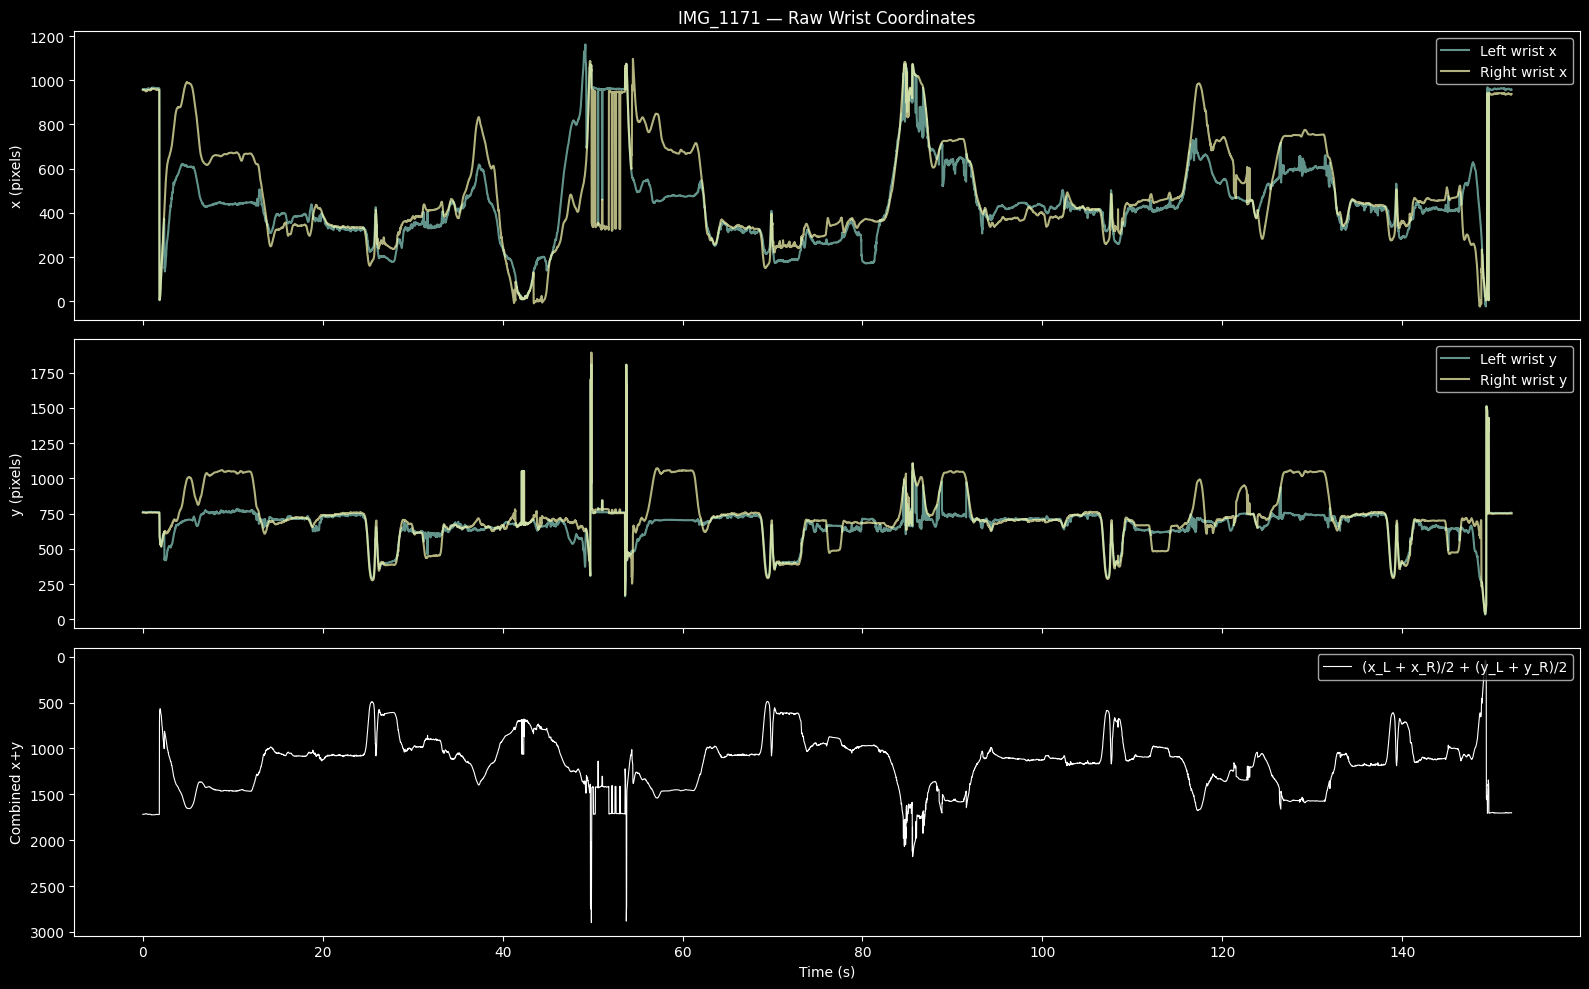

In [3]:
#| label: raw-wrist-signals
#| fig-cap: "Raw wrist x and y coordinates. Each dip in x and y together corresponds to a backswing."
t = np.arange(n_frames) / fps

fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

axes[0].plot(t, x_l, alpha=0.7, label="Left wrist x")
axes[0].plot(t, x_r, alpha=0.7, label="Right wrist x")
axes[0].set_ylabel("x (pixels)")
axes[0].legend(loc="upper right")
axes[0].set_title(f"{VID_NAME} — Raw Wrist Coordinates")

axes[1].plot(t, y_l, alpha=0.7, label="Left wrist y")
axes[1].plot(t, y_r, alpha=0.7, label="Right wrist y")
axes[1].set_ylabel("y (pixels)")
axes[1].legend(loc="upper right")

combined_raw = (x_l + x_r) / 2.0 + (y_l + y_r) / 2.0
axes[2].plot(t, combined_raw, color="white", linewidth=0.8, label="(x_L + x_R)/2 + (y_L + y_R)/2")
axes[2].set_ylabel("Combined x+y")
axes[2].set_xlabel("Time (s)")
axes[2].legend(loc="upper right")
axes[2].invert_yaxis()

fig.tight_layout()
display(fig); plt.close(fig)

The combined signal (bottom panel, y-axis inverted so peaks = backswings) already shows clear dips at each swing. But it's noisy --- mmpose drops confidence on some frames and the raw signal is too jittery for reliable peak detection.

## Step 1: Interpolate Low-Confidence Frames

Before smoothing, we replace frames where mmpose had low confidence (`< 0.3`) with linearly interpolated values from the neighbors. Gets rid of the worst spikes without distorting the actual trajectory.

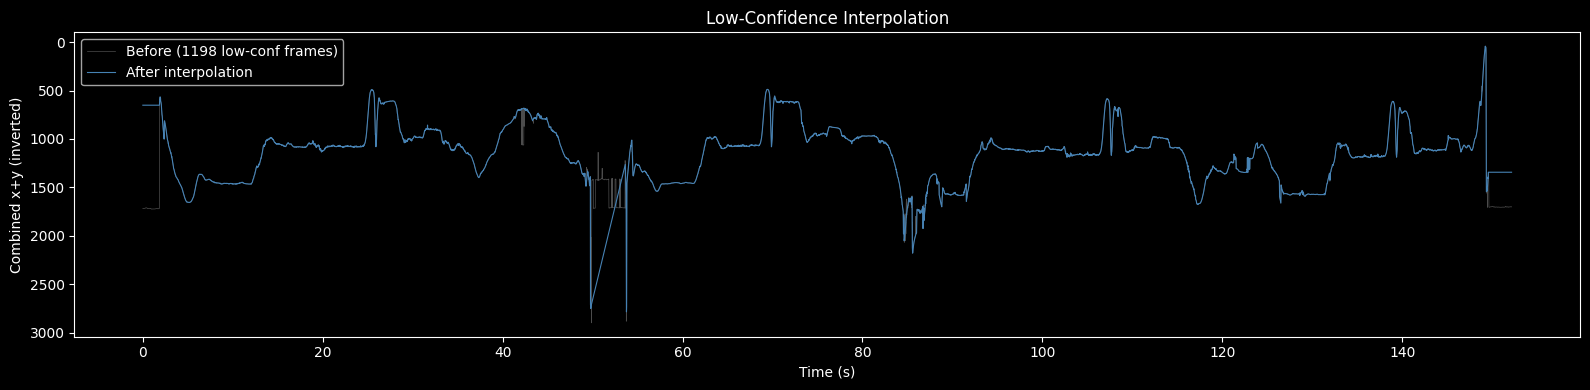

In [4]:
#| label: interpolation
#| fig-cap: "Effect of confidence-based interpolation on the combined signal."
# Interpolate
x_l_i = _interp_low_conf(x_l, c_l, cfg.conf_threshold)
x_r_i = _interp_low_conf(x_r, c_r, cfg.conf_threshold)
y_l_i = _interp_low_conf(y_l, c_l, cfg.conf_threshold)
y_r_i = _interp_low_conf(y_r, c_r, cfg.conf_threshold)
combined = (x_l_i + x_r_i) / 2.0 + (y_l_i + y_r_i) / 2.0

n_bad_l = np.sum(c_l < cfg.conf_threshold)
n_bad_r = np.sum(c_r < cfg.conf_threshold)

fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(t, combined_raw, color="gray", linewidth=0.5, alpha=0.6, label=f"Before ({n_bad_l + n_bad_r} low-conf frames)")
ax.plot(t, combined, color="steelblue", linewidth=0.8, label="After interpolation")
ax.invert_yaxis()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Combined x+y (inverted)")
ax.set_title("Low-Confidence Interpolation")
ax.legend()
fig.tight_layout()
display(fig); plt.close(fig)

## Step 2: Two-Pass Smoothing

We smooth at two different scales using [Savitzky-Golay filters](https://en.wikipedia.org/wiki/Savitzky%%E2%%80%%93Golay_filter), and each one has a specific job:

| Filter | Window | Real-world span | Purpose |
|--------|--------|-----------------|---------|
| **Fine** | 9 frames | ~150ms | Remove frame-to-frame jitter while preserving the exact shape of each swing |
| **Coarse** | 61 frames | ~1.0s | Flatten within-swing oscillations to find *candidate regions* for backswing search |

Why 61 for coarse? A swing is 2--3 seconds. Smoothing over ~1 second is wide enough to eliminate the fast downswing/contact spike within a single swing cycle, leaving just the slow envelope that marks where swings happen. It's deliberately too wide to pinpoint the exact apex --- we handle that later.

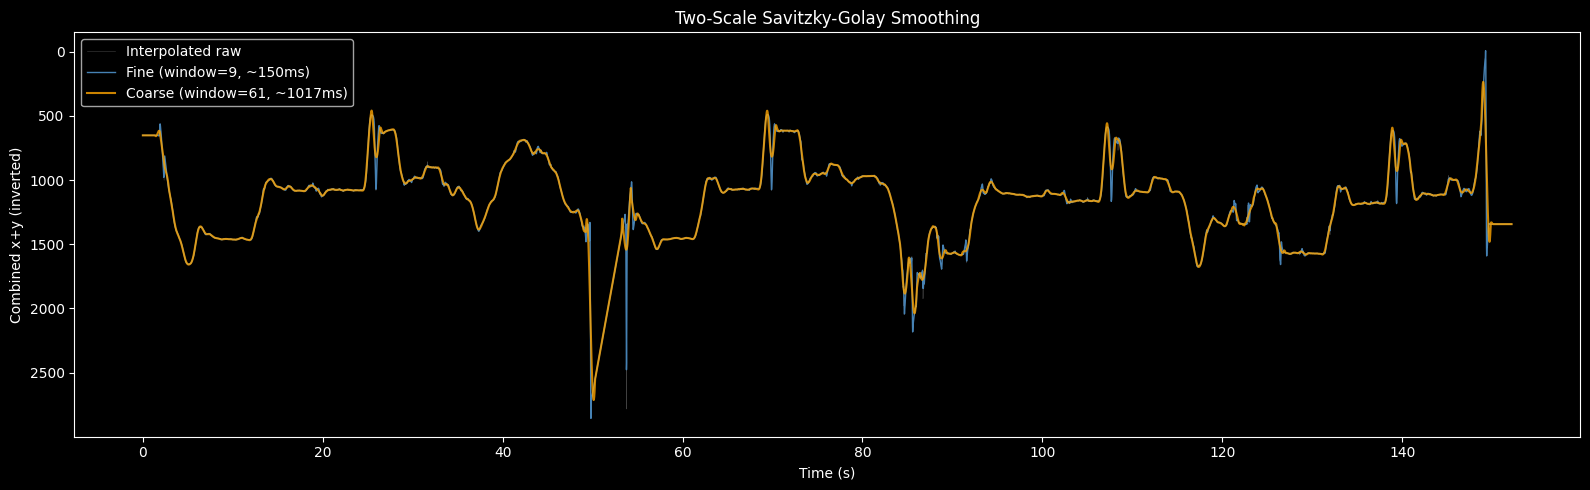

In [5]:
#| label: smoothing
#| fig-cap: "Fine (150ms) vs. coarse (1s) Savitzky-Golay smoothing. The coarse curve identifies swing regions; the fine curve preserves the exact peak shape."
smoothed_fine = savgol_filter(combined, cfg.savgol_window, cfg.savgol_poly)
smoothed_coarse = savgol_filter(combined, cfg.coarse_window, cfg.coarse_poly)

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(t, combined, color="gray", linewidth=0.4, alpha=0.5, label="Interpolated raw")
ax.plot(t, smoothed_fine, color="steelblue", linewidth=1.0, label=f"Fine (window={cfg.savgol_window}, ~{cfg.savgol_window/fps*1000:.0f}ms)")
ax.plot(t, smoothed_coarse, color="orange", linewidth=1.5, alpha=0.8, label=f"Coarse (window={cfg.coarse_window}, ~{cfg.coarse_window/fps*1000:.0f}ms)")
ax.invert_yaxis()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Combined x+y (inverted)")
ax.set_title("Two-Scale Savitzky-Golay Smoothing")
ax.legend()
fig.tight_layout()
display(fig); plt.close(fig)

The coarse curve (orange) rounds off the sharp peaks --- that's by design. The fine curve (blue) tracks the actual apex much more faithfully. We use coarse for *finding* swings and fine for *locating* them precisely.

## Step 3: Peak Detection

We flip the fine-smoothed signal and run `scipy.signal.find_peaks` to find local maxima (= backswing tops in the original signal).

| Parameter | Value | Meaning |
|-----------|-------|---------|
| `peak_prominence` | 300 px | A swing must produce at least a 300-pixel dip in the combined signal |
| `peak_distance` | 500 frames (~8.3s) | Two peaks must be at least 8 seconds apart |

These are intentionally generous --- we'd rather over-detect here and let the filters clean up later.

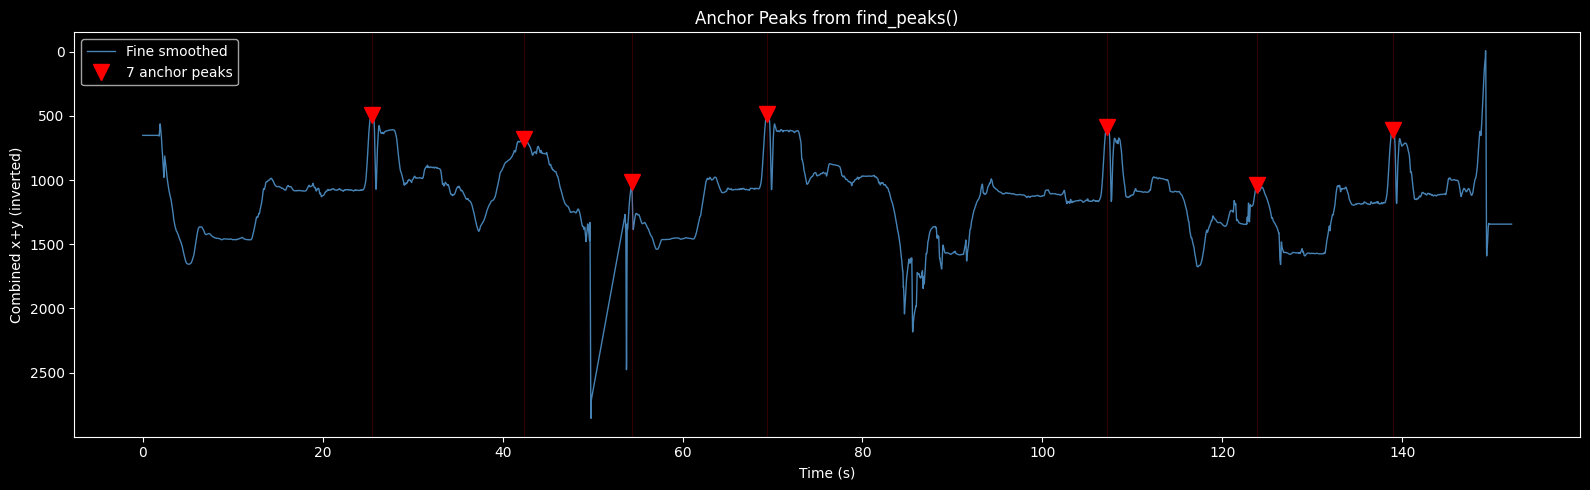

In [6]:
#| label: raw-peaks
#| fig-cap: "Initial peak detection on the inverted signal. These are anchor points --- the coarse search will refine them."
neg = -smoothed_fine.copy()
# End-of-video masking: suppress the last 5% of frames
mask_start = int(total_frames * 0.95)
if mask_start < len(neg):
    neg[mask_start:] = np.min(neg)

anchors, props = find_peaks(neg, prominence=cfg.peak_prominence, distance=cfg.peak_distance)

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(t, smoothed_fine, color="steelblue", linewidth=1.0, label="Fine smoothed")
ax.invert_yaxis()
if len(anchors) > 0:
    ax.plot(anchors / fps, smoothed_fine[anchors], "rv", markersize=12, label=f"{len(anchors)} anchor peaks")
    for a in anchors:
        ax.axvline(a / fps, color="red", alpha=0.2, linewidth=0.8)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Combined x+y (inverted)")
ax.set_title("Anchor Peaks from find_peaks()")
ax.legend()
fig.tight_layout()
display(fig); plt.close(fig)

## Step 4: Backswing Scoring

The peaks from `find_peaks` land in the right neighborhood but sometimes on the **follow-through** instead of the backswing (both have low x+y). For each anchor, we search backward up to 600 frames (~10s) on the coarse signal for candidate local minima, then score each one:

$$\text{score} = \underbrace{\text{std}(\Delta\text{signal}_{\text{behind}})}_{\text{approach jitter}} - 0.5 \times \underbrace{(\text{signal}_{\text{ahead}}[-1] - \text{signal}_{\text{ahead}}[0])}_{\text{departure drop}}$$

The idea: a real backswing has a **smooth approach** (slowly raising the club) and a **sharp departure** (the fast downswing). Follow-throughs have it backwards --- sharp approach, slow departure. Lowest score wins.

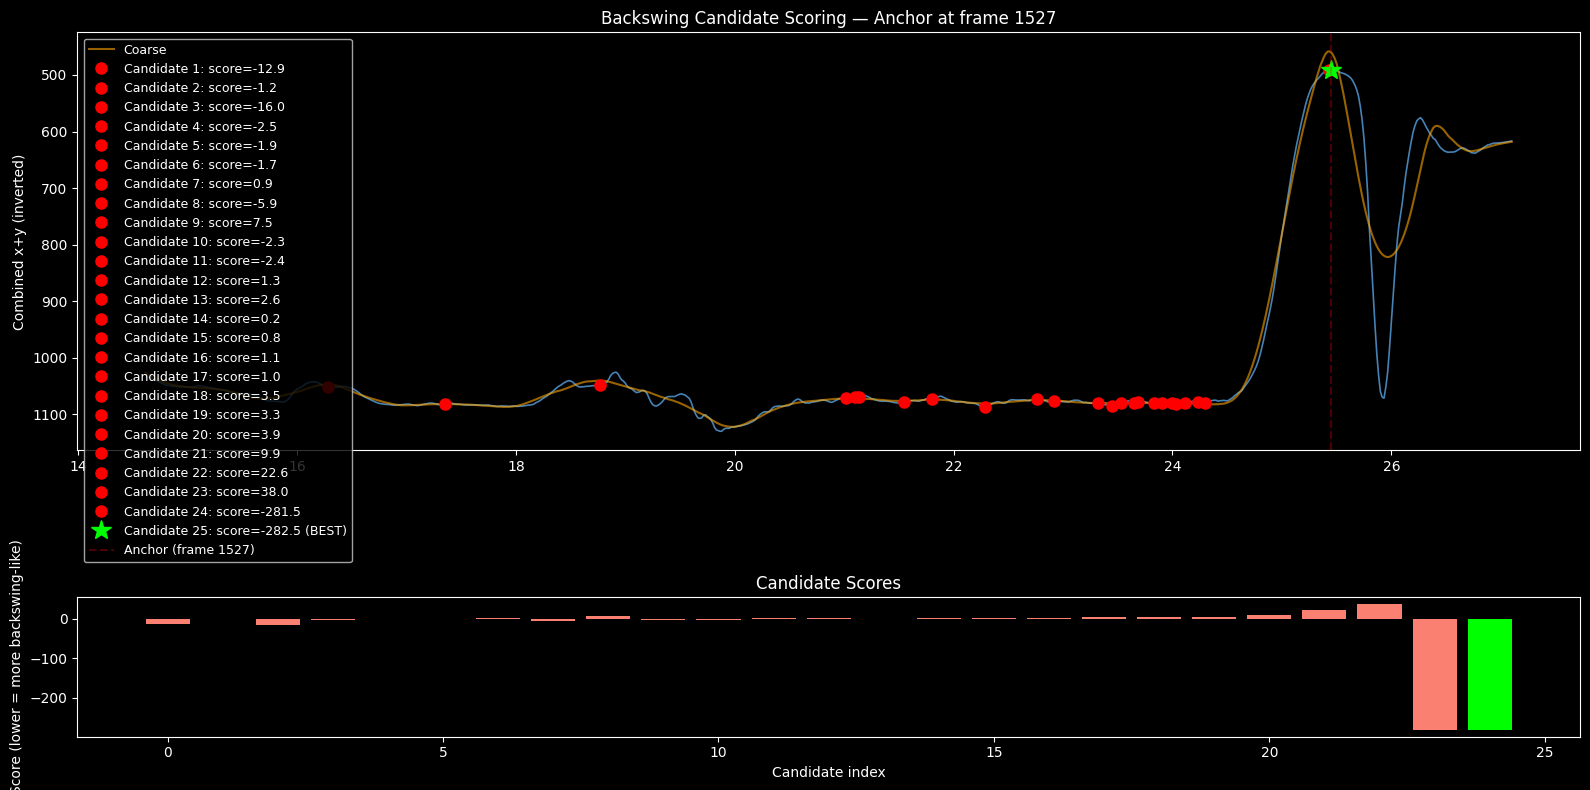

In [7]:
#| label: scoring-demo
#| fig-cap: "Backswing scoring for one anchor: the true backswing (green) has a smooth approach and sharp departure, while a follow-through candidate would score higher."
# Show scoring for the first anchor
if len(anchors) > 0:
    anchor = anchors[0]
    ss = max(0, anchor - cfg.search_back)
    d = np.diff(smoothed_coarse[ss:anchor + 1])
    candidates = [ss + i + 1 for i in range(len(d) - 1) if d[i] <= 0 and d[i + 1] > 0]
    if anchor not in candidates:
        candidates.append(anchor)

    scores = [_backswing_score(c, smoothed_fine, cfg) for c in candidates]
    best_idx = np.argmin(scores)
    best = candidates[best_idx]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), gridspec_kw={"height_ratios": [3, 1]})

    # Signal with candidates
    region = slice(max(0, ss - 50), min(len(smoothed_fine), anchor + 100))
    t_region = np.arange(region.start, region.stop) / fps
    ax1.plot(t_region, smoothed_fine[region], color="steelblue", linewidth=1.2)
    ax1.plot(t_region, smoothed_coarse[region], color="orange", linewidth=1.5, alpha=0.6, label="Coarse")
    for i, c in enumerate(candidates):
        color = "lime" if i == best_idx else "red"
        marker = "*" if i == best_idx else "o"
        size = 15 if i == best_idx else 8
        ax1.plot(c / fps, smoothed_fine[c], marker, color=color, markersize=size,
                 label=f"Candidate {i+1}: score={scores[i]:.1f}" + (" (BEST)" if i == best_idx else ""))
    ax1.axvline(anchor / fps, color="red", alpha=0.3, linestyle="--", label=f"Anchor (frame {anchor})")
    ax1.invert_yaxis()
    ax1.set_ylabel("Combined x+y (inverted)")
    ax1.set_title(f"Backswing Candidate Scoring — Anchor at frame {anchor}")
    ax1.legend(fontsize=9)

    # Score bar chart
    ax2.bar(range(len(scores)), scores, color=["lime" if i == best_idx else "salmon" for i in range(len(scores))])
    ax2.set_xlabel("Candidate index")
    ax2.set_ylabel("Score (lower = more backswing-like)")
    ax2.set_title("Candidate Scores")

    fig.tight_layout()
    display(fig); plt.close(fig)

## Step 5: Apex Refinement

The coarse search gets the right swing, but the wide smoothing flattens the peak by ~10 frames --- the candidate lands on the rising slope *before* the true apex.

Easy fix: from the best candidate, search forward up to 15 frames (~250ms) on the fine-smoothed signal for the actual minimum.

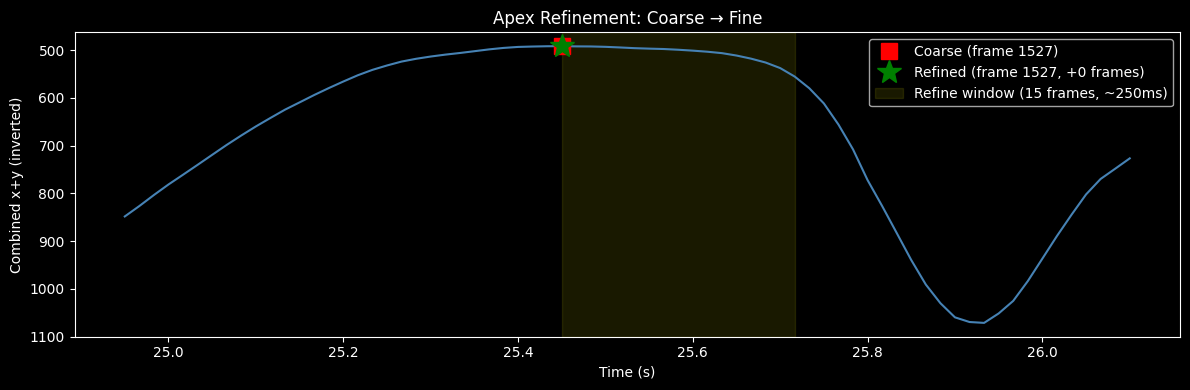

In [8]:
#| label: refinement
#| fig-cap: "Apex refinement: the coarse candidate (red) lands early; the refinement step (green) finds the true minimum within 15 frames."
if len(anchors) > 0:
    # best from the scoring step above
    refine_end = min(len(smoothed_fine), best + cfg.refine_window + 1)
    refine_seg = smoothed_fine[best:refine_end]
    refined = best + int(np.argmin(refine_seg))

    fig, ax = plt.subplots(figsize=(12, 4))
    window = slice(max(0, best - 30), min(len(smoothed_fine), refined + 40))
    t_w = np.arange(window.start, window.stop) / fps
    ax.plot(t_w, smoothed_fine[window], color="steelblue", linewidth=1.5)
    ax.plot(best / fps, smoothed_fine[best], "rs", markersize=12, label=f"Coarse (frame {best})")
    ax.plot(refined / fps, smoothed_fine[refined], "g*", markersize=18, label=f"Refined (frame {refined}, +{refined - best} frames)")
    ax.axvspan(best / fps, refine_end / fps, color="yellow", alpha=0.1, label=f"Refine window ({cfg.refine_window} frames, ~{cfg.refine_window/fps*1000:.0f}ms)")
    ax.invert_yaxis()
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Combined x+y (inverted)")
    ax.set_title("Apex Refinement: Coarse → Fine")
    ax.legend()
    fig.tight_layout()
    display(fig); plt.close(fig)

15 frames at 60fps is ~250ms --- way too short to jump to the next swing's follow-through, but enough to correct the ~10 frame bias from coarse smoothing.

## Step 6: Filter Pipeline

After detection, five filters run in sequence to clean up false positives:

In [9]:
#| label: full-detection
#| fig-cap: "Full detection pipeline on a single video, showing all detected backswing tops."
result = detect_backswings(PKL_PATH, MOV_PATH, config=cfg)
print(f"{result.name}: {result.n_swings} swings detected")
for msg in result.filter_log:
    print(f"  {msg}")

IMG_1171: 4 swings detected
  Too-close: removed 1 peak(s) within 600 frames
  MAD: removed 2 peak(s) with x+y > 926 (med=599, MAD=109)


The filters, in order:

1. **Dedup** --- merge when two anchors converge to the same frame
2. **End-of-video trim** --- drop peaks in the last 3% of frames (camera noise, golfer walking away)
3. **Too-close merge** --- if two peaks are within 600 frames (~10s), keep the deeper one
4. **MAD outlier removal** --- compute the median absolute deviation of x+y values at all peaks; remove any peak more than 3 MADs above median. A floor of 50 prevents this from getting unreasonably tight when all swings are very consistent
5. **Follow-through rejection** --- check horizontal offset of wrists vs. shoulders. Real backswings have hands *behind* the body (negative offset); follow-throughs have hands *in front* (positive). Remove peaks with offset more than 3 MADs above median.

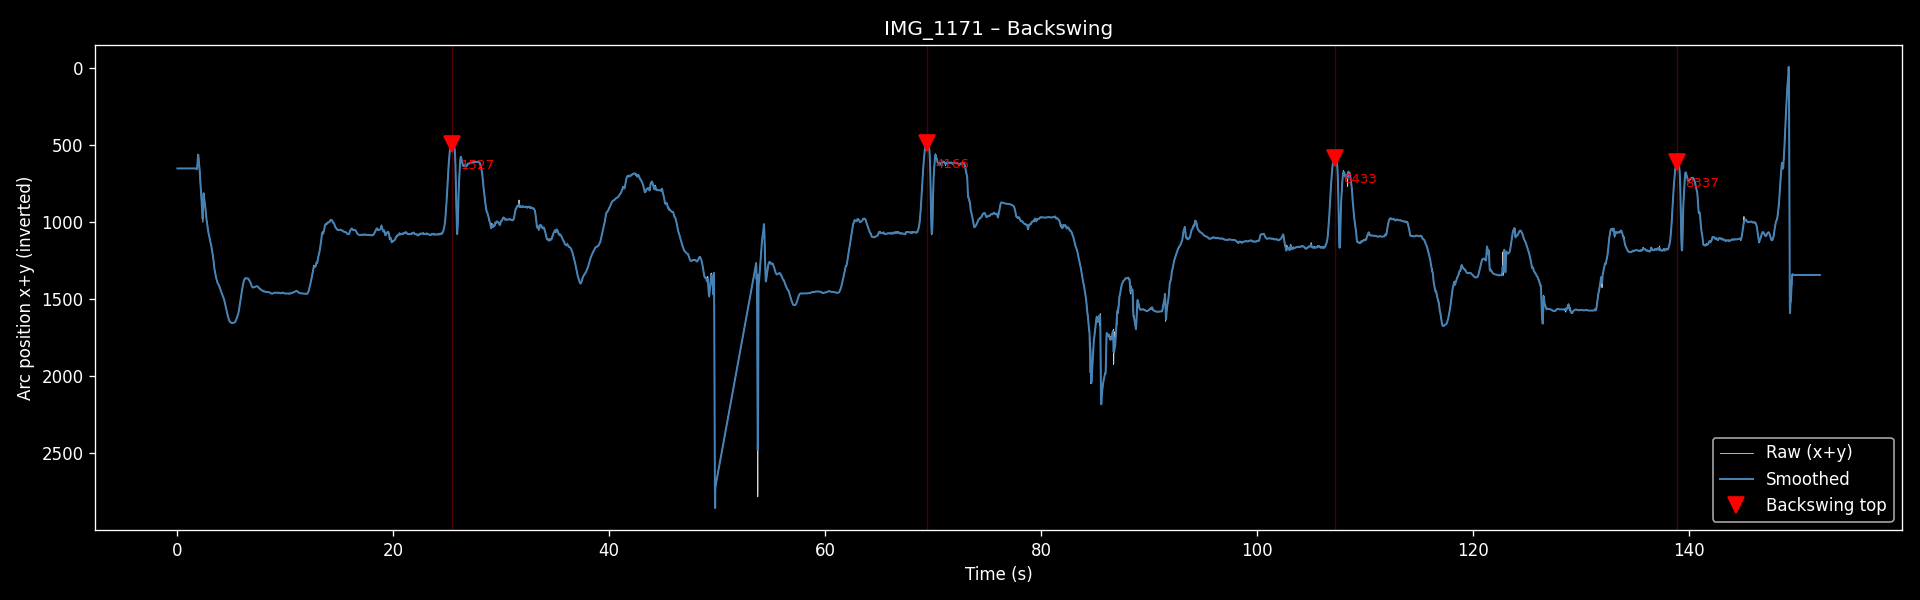

In [10]:
#| label: signal-plot
#| fig-cap: "Final detected backswing tops overlaid on the smoothed signal."
from end2end.visualize import make_signal_plot

out_dir = os.path.join(os.getcwd(), "_notebook_output")
os.makedirs(out_dir, exist_ok=True)
path = make_signal_plot(result, out_dir)
display(IPImage(filename=path))

## Visualizing the Detections

For each detected frame we pull the actual video frame and overlay the COCO-17 skeleton with wrists highlighted --- quick sanity check that we landed on the right moment.

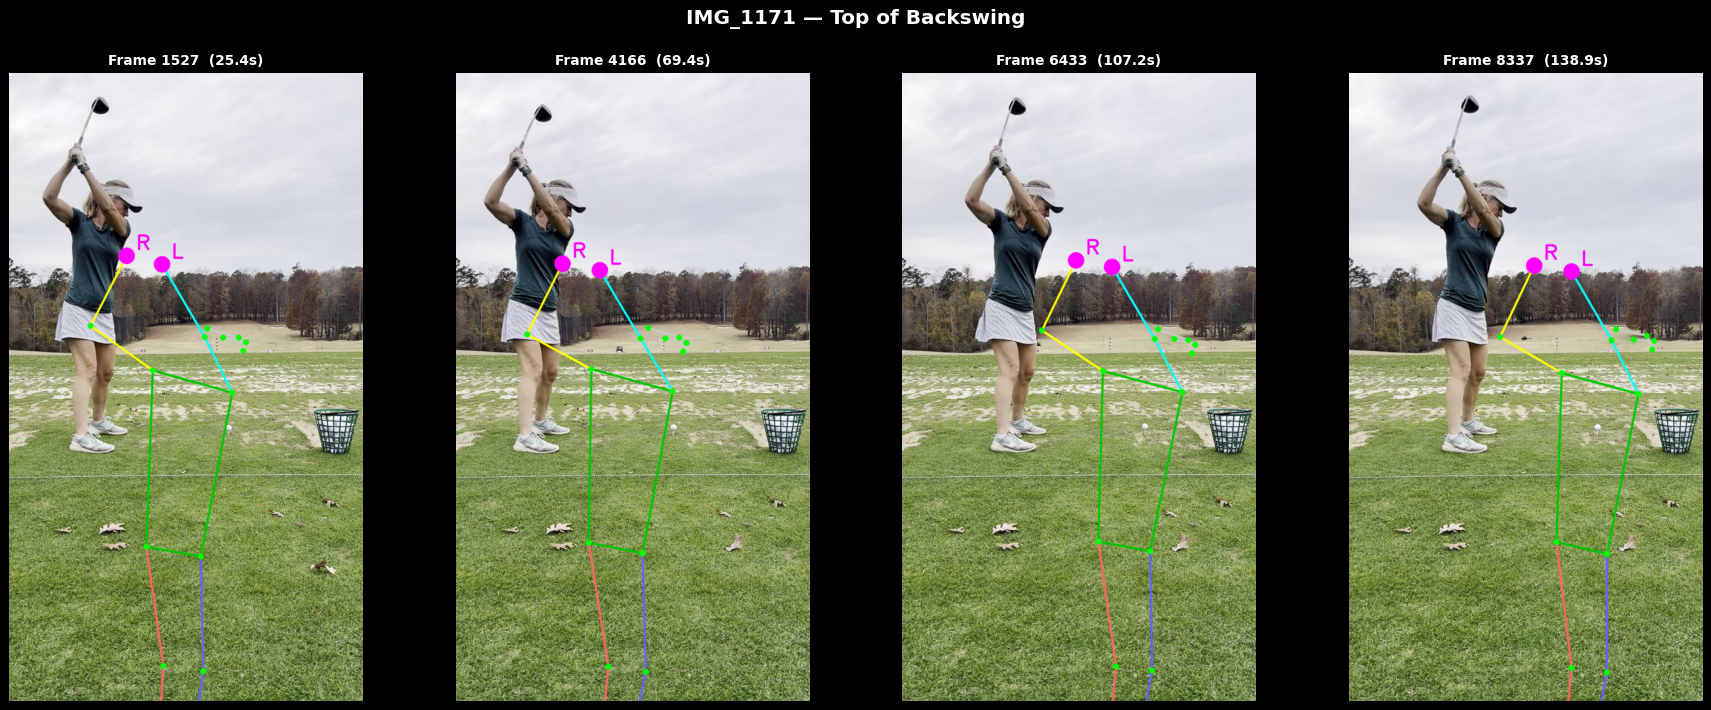

In [11]:
#| label: skeleton-grid
#| fig-cap: "Skeleton overlay at each detected backswing top. Wrists (magenta) should be high and behind the head."
from end2end.visualize import make_grid

grid_path = make_grid(
    result.peak_frames, result.pkl_data, result.mov_path, result.fps,
    f"{result.name} — Top of Backswing",
    os.path.join(out_dir, f"{result.name}_backswing_grid.png"),
)
if grid_path:
    display(IPImage(filename=grid_path))

## Contact Detection

Once we have the backswing tops, finding contact is straightforward: for each backswing frame, search forward 10--90 frames (~170ms to 1.5s) for the maximum of a tightly smoothed signal (window=5, ~83ms). That's where the hands are fully extended --- club meeting ball.

In [12]:
#| label: contact
#| fig-cap: "Backswing tops (red triangles) and contact points (green triangles) with arrows showing each downswing."
ct = detect_contacts(result, config=cfg)
print(f"{ct.name}: {ct.n_contacts} contact points")

# Downswing durations
for i in range(min(len(result.peak_frames), len(ct.contact_frames))):
    bs_f, ct_f = result.peak_frames[i], ct.contact_frames[i]
    gap = ct_f - bs_f
    print(f"  Swing {i+1}: backswing frame {bs_f} → contact frame {ct_f} = {gap} frames ({gap/fps*1000:.0f}ms downswing)")

IMG_1171: 4 contact points
  Swing 1: backswing frame 1527 → contact frame 1554 = 27 frames (450ms downswing)
  Swing 2: backswing frame 4166 → contact frame 4193 = 27 frames (450ms downswing)
  Swing 3: backswing frame 6433 → contact frame 6460 = 27 frames (450ms downswing)
  Swing 4: backswing frame 8337 → contact frame 8363 = 26 frames (433ms downswing)


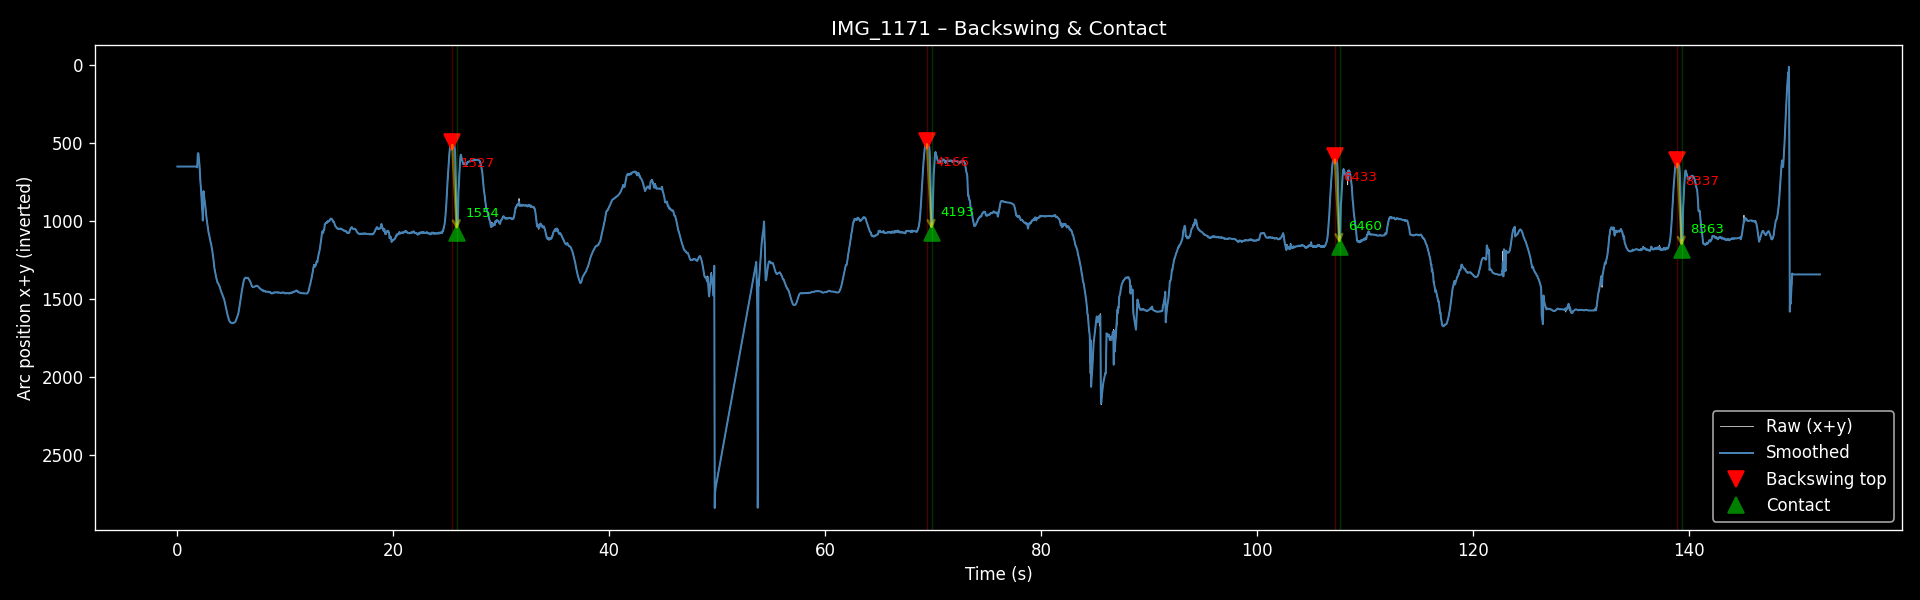

In [13]:
#| label: contact-signal
#| fig-cap: "Combined signal with both backswing and contact landmarks."
path = make_signal_plot(result, out_dir, contact_result=ct)
display(IPImage(filename=path))

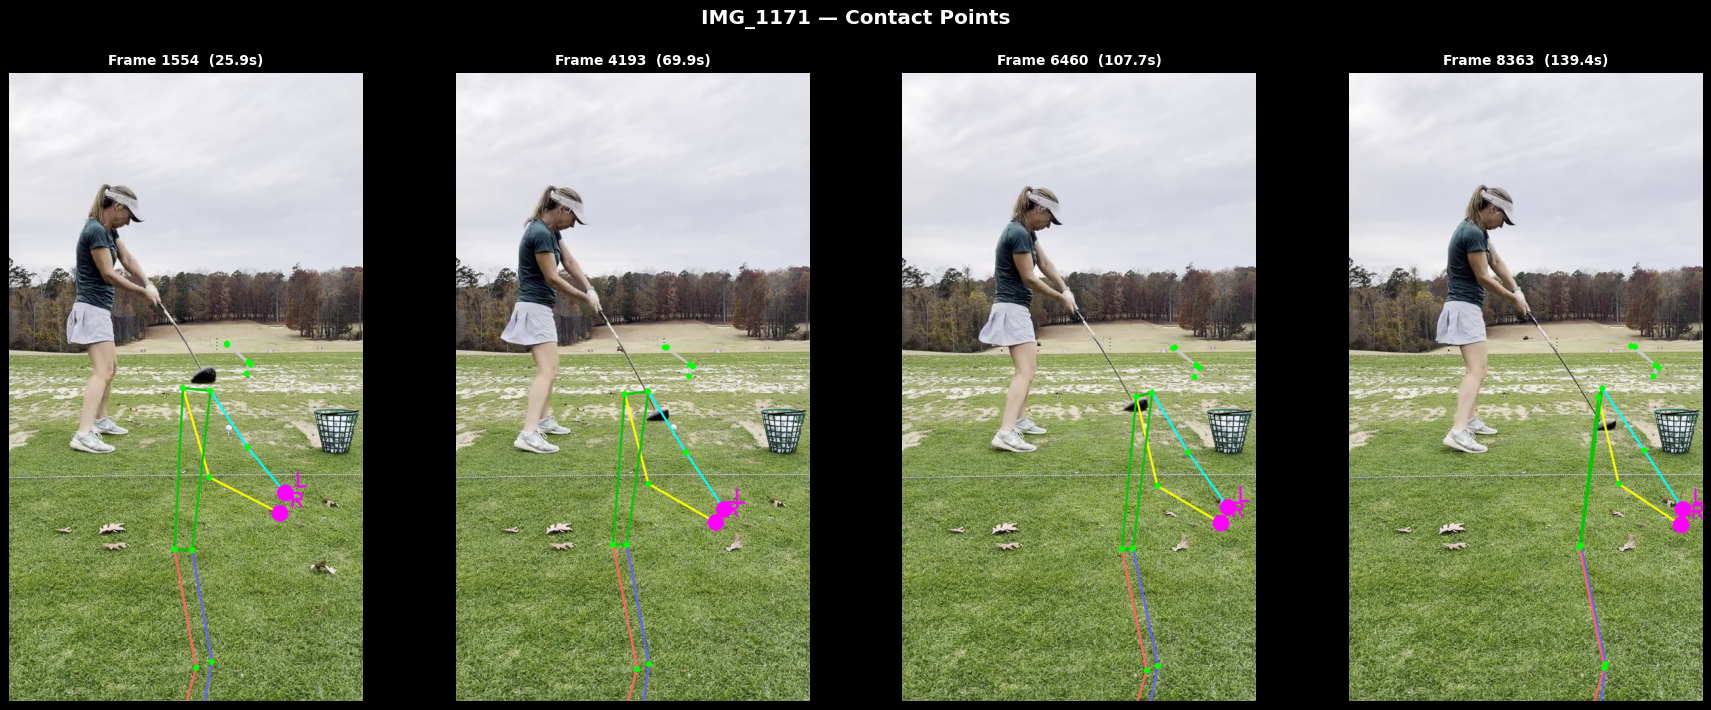

In [14]:
#| label: contact-grid
#| fig-cap: "Skeleton overlay at contact points. Wrists should be low and forward — the moment of impact."
grid_path = make_grid(
    ct.contact_frames, result.pkl_data, result.mov_path, result.fps,
    f"{result.name} — Contact Points",
    os.path.join(out_dir, f"{result.name}_contact_grid.png"),
)
if grid_path:
    display(IPImage(filename=grid_path))

## Parameter Reference

All parameters live in a single frozen dataclass (`Config`) with defaults tuned on two datasets (7 + 10 videos, 92 total swings):

In [15]:
#| label: param-table
#| code-fold: true
import pandas as pd

params = [
    ("savgol_window", cfg.savgol_window, f"~{cfg.savgol_window/fps*1000:.0f}ms", "Fine smoothing — removes jitter, preserves swing shape"),
    ("savgol_poly", cfg.savgol_poly, "—", "Polynomial order for fine Savitzky-Golay"),
    ("coarse_window", cfg.coarse_window, f"~{cfg.coarse_window/fps*1000:.0f}ms", "Coarse smoothing — finds swing regions, too wide for exact apex"),
    ("peak_prominence", cfg.peak_prominence, "300 px", "Minimum signal dip to count as a swing"),
    ("peak_distance", cfg.peak_distance, f"~{cfg.peak_distance/fps:.1f}s", "Minimum gap between find_peaks detections"),
    ("search_back", cfg.search_back, f"~{cfg.search_back/fps:.1f}s", "How far back from anchor to search for the true backswing"),
    ("refine_window", cfg.refine_window, f"~{cfg.refine_window/fps*1000:.0f}ms", "Forward search on fine signal to correct coarse bias"),
    ("min_swing_gap", cfg.min_swing_gap, f"~{cfg.min_swing_gap/fps:.1f}s", "Merge threshold for too-close peaks"),
    ("end_of_video_pct", cfg.end_of_video_pct, f"Last {cfg.end_of_video_pct*100:.0f}%", "Suppress peaks in final frames (noise from camera stop)"),
    ("xy_outlier_mad_floor", cfg.xy_outlier_mad_floor, "50 px", "Prevents MAD threshold from being too tight when swings are consistent"),
    ("contact_search_min/max", f"{cfg.contact_search_min}–{cfg.contact_search_max}",
     f"~{cfg.contact_search_min/fps*1000:.0f}–{cfg.contact_search_max/fps*1000:.0f}ms",
     "Window after backswing to search for impact"),
]
df = pd.DataFrame(params, columns=["Parameter", "Value", "Physical meaning", "Purpose"])
df.style.hide(axis="index")

## Running on a Full Dataset

The batch runner auto-discovers videos and produces per-video grids, signal plots, optional clips, and a problems report:

```bash
conda activate fastdl

# Backswing only
python -m end2end.run_batch ../saugusta --no-clips --no-pushover

# Backswing + contact + CSV export
python -m end2end.run_batch ../oct25 --contact --csv --no-pushover
```

In [ ]:
#| label: batch-summary
#| code-fold: true
# Run detection across all saugusta videos to show aggregate results
from end2end.pipeline import detect_backswings, detect_contacts
from end2end.run_batch import discover_videos

videos = discover_videos(DATASET)
all_results = []
for name, paths in videos.items():
    r = detect_backswings(paths["pkl"], paths["mov"], config=cfg)
    all_results.append(r)

total = sum(r.n_swings for r in all_results)
print(f"Dataset: saugusta — {len(all_results)} videos, {total} total swings\n")
for r in all_results:
    filters = [m.split(":")[0] for m in r.filter_log]
    line = f"  {r.name}: {r.n_swings} swings"
    if filters:
        line += f"  [{', '.join(filters)}]"
    print(line)

## What Can Go Wrong

The pipeline gets 92/92 detections with zero false positives, but only after fixing three subtle failure modes.

### MAD Floor --- When Consistency Kills

When all swings in a video have very similar x+y values (MAD of 14--19 pixels), the outlier threshold `median + 3 * MAD` becomes absurdly tight. Valid swings that are barely above it get rejected.

**Fix:** `max(mad, 50)` before computing the threshold --- a floor that prevents the filter from being *too* discriminating.

### End-of-Video Noise

The last few percent of a video often has the golfer walking away or the camera shutting off. These frames produce spurious peaks that suppress nearby real peaks via `find_peaks`'s distance parameter.

**Fix:** Before calling `find_peaks`, set the last 3% of the inverted signal to its global minimum. Zero-costs the noise region without touching any real swing.

### Coarse Smoothing Bias

The coarse Savitzky-Golay filter (window=61) flattens peaks by ~10 frames. The scoring function then *prefers* the early (wrong) candidate because the remaining rise looks like a "sharp departure."

**Fix:** 15-frame forward refinement on the fine-smoothed signal after scoring. Safe because 15 frames (~250ms) is way too short to reach the follow-through.

## Summary

The full pipeline:

```
Raw wrist keypoints (x, y per frame)
  → Interpolate low-confidence frames
  → Combined signal: (x_L + x_R)/2 + (y_L + y_R)/2
  → Fine smooth (9 frames / 150ms) + Coarse smooth (61 frames / 1.0s)
  → find_peaks on inverted signal (anchors)
  → Backward search on coarse signal (candidate regions)
  → Backswing scoring (smooth approach + sharp departure)
  → Apex refinement (+15 frames on fine signal)
  → Five-stage filtering (dedup, end-trim, merge, MAD, follow-through)
  → Contact search (forward 10-90 frames for max)
```

~570 lines of Python. Just wrist positions and a Savitzky-Golay filter.